<a href="https://colab.research.google.com/github/euguroglu/Machine-Learning-Projects/blob/master/Pytorch_Neural_Network_New_York_City_Taxi_Fare_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [17]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv('NYCTaxiFares.csv')

In [19]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


For classification problem we are focussing fare_class instead of fare_amount note that class is 1 if fare is higher than 10 dollar and 0 otherwise

In [20]:
df['fare_class'].value_counts()

0    80000
1    40000
Name: fare_class, dtype: int64

## Feature Engineering

Haversine equation calculates distances of the fare using latitude and longitude values 

In [21]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

Usin new value we create new column

In [22]:
df['dist_km'] = haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [23]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


When we check dataframe info we see that datetime is object,lets convert it to the date_time object using below code

In [25]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

Now we see that type is changed to datetime

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


There is 4 hours differences because of the daylight saving 

In [28]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

Using date_time colums we can create usefull data like below

In [29]:
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


## Separating categorical data and continous data

In [30]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_class']  # this column contains the labels

In [31]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

We can see that df['Hour'] is a categorical feature by displaying some of the rows:

In [32]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Using cat.categories code we can see unique category units like below

In [33]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

We can see numerical representation using below code

In [34]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [35]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [36]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

Combining categorical values usinig np.stack

Note that .values command converting pandas series to numpy arrays

In [37]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

Converting categorical arrays into tensor

In [40]:
# Convert categorical variables to a tensor
cats = torch.LongTensor(cats)
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

Converting continous variables into tensor

In [41]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.FloatTensor(conts)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

Note: the CrossEntropyLoss function we'll use below expects a 1d y-tensor, so we'll replace .reshape(-1,1) with .flatten() this time.

In [42]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values).flatten()

y[:5]

tensor([0, 0, 1, 0, 1])

## Setting embedding sizes

In [43]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## Neural Network

In [44]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [45]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) # out_sz = 2

In [46]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [47]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss performs better for classification tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
batch_size = 60000
test_size = 12000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [53]:
len(cat_train)

48000

In [54]:
len(cat_test)

12000

In [56]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print('Epoch: {} and Loss: {:8.4f}'.format(i,loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch: 1 and Loss:   0.8330
Epoch: 11 and Loss:   0.4881
Epoch: 21 and Loss:   0.3982
Epoch: 31 and Loss:   0.3646
Epoch: 41 and Loss:   0.3485
Epoch: 51 and Loss:   0.3353
Epoch: 61 and Loss:   0.3267
Epoch: 71 and Loss:   0.3184
Epoch: 81 and Loss:   0.3106
Epoch: 91 and Loss:   0.3051
Epoch: 101 and Loss:   0.2994
Epoch: 111 and Loss:   0.2977
Epoch: 121 and Loss:   0.2941
Epoch: 131 and Loss:   0.2922
Epoch: 141 and Loss:   0.2896
Epoch: 151 and Loss:   0.2864
Epoch: 161 and Loss:   0.2833
Epoch: 171 and Loss:   0.2817
Epoch: 181 and Loss:   0.2804
Epoch: 191 and Loss:   0.2783
Epoch: 201 and Loss:   0.2750
Epoch: 211 and Loss:   0.2726
Epoch: 221 and Loss:   0.2709
Epoch: 231 and Loss:   0.2682
Epoch: 241 and Loss:   0.2651
Epoch: 251 and Loss:   0.2653
Epoch: 261 and Loss:   0.2645
Epoch: 271 and Loss:   0.2627
Epoch: 281 and Loss:   0.2591
Epoch: 291 and Loss:   0.2588
epoch: 300  loss: 0.25800189

Duration: 357 seconds


## Cost function convergence

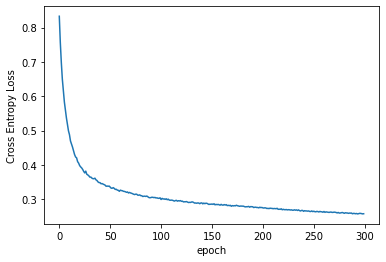

In [57]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

Evaluation

In [58]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.25510740


## Prediction

In [59]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 2.7657, -2.3629])    0      0   
tensor([-2.3027,  2.7530])    1      0   
tensor([ 2.8005, -1.3440])    0      0   
tensor([-1.9072,  1.2199])    1      1   
tensor([ 2.3959, -1.9118])    0      0   
tensor([ 1.4882, -1.7101])    0      0   
tensor([ 2.9020, -1.3928])    0      0   
tensor([-2.5014,  1.2572])    1      1   
tensor([ 1.5455, -1.6115])    0      0   
tensor([-0.6138,  0.6314])    1      1   
tensor([ 1.3007, -2.5816])    0      0   
tensor([ 1.8509, -1.2808])    0      0   
tensor([ 2.1663, -0.8695])    0      0   
tensor([-2.2796,  1.1396])    1      1   
tensor([ 1.9634, -1.9860])    0      0   
tensor([-3.6262,  1.2763])    1      1   
tensor([ 2.1513, -1.8132])    0      1   
tensor([ 2.9426, -0.9463])    0      0   
tensor([ 0.3013, -1.1233])    0      0   
tensor([ 1.7160, -2.2084])    0      0   
tensor([-2.5324,  1.8087])    1      1   
tensor([-0.5080,  0.1678])    1      1   
tensor([-3.4763,  2.4708])    1   